In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from tqdm import tqdm

# Data

In [2]:
access = gpd.read_file("./data/processed_data/ICU_access_measures/ICU_access_county.shp")
access.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057078,0.055447,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710..."
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.007549,0.006805,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8..."
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.001716,0.001967,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0..."
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.138889,0.120955,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508..."
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.001702,0.002336,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813..."


In [3]:
death = gpd.read_file("./data/processed_data/relationship/seven_day_ratio.shp")
death.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,TSA,geometry
0,48327,Menard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,K,"POLYGON ((-99.77120 30.71079, -99.78240 30.710..."
1,48189,Hale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,...,71.428571,80.0,75.471698,59.701493,60.606061,32.786885,52.631579,104.166667,B,"POLYGON ((-101.73504 33.82864, -101.73507 33.8..."
2,48011,Armstrong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A,"POLYGON ((-101.08728 35.02708, -101.08729 35.0..."
3,48057,Calhoun,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,S,"POLYGON ((-96.35229 28.50953, -96.35241 28.508..."
4,48077,Clay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,C,"POLYGON ((-97.97784 33.81417, -97.97784 33.813..."


# Pearson

In [4]:
pearson_dict = dict()
for ind in tqdm(access["index"], position=0):
    acc_ts = access.loc[access["index"] == ind].copy(deep=True)
    assert len(acc_ts) == 1
    acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
    acc_ts = acc_ts.T
    acc_ts.columns = ["access"]
    # print(type(acc_ts))
    # acc_ts.head()

    death_ts = death.loc[death["index"] == ind].copy(deep=True)
    assert len(death_ts) == 1
    death_ts = death_ts.drop(columns=["index", "NAME", "TSA", "geometry"])
    # print(list(death_ts.columns))
    death_ts = death_ts.T
    death_ts.columns = ["death"]
    # print(type(death_ts))
    # death_ts.head()

    # need to make the data stationary
    # https://stackoverflow.com/questions/51772493/understanding-output-from-statsmodels-grangercausalitytests
    # https://en.wikipedia.org/wiki/Granger_causality#Method
    #data = acc_ts.join(death_ts)
    #print(len(data))
    x = acc_ts["access"]
    y = death_ts["death"]
    pearr, pearp = pearsonr(x, y)
    pearson_dict[ind] = dict()
    pearson_dict[ind]["coef"] = pearr
    pearson_dict[ind]["pval"] = pearp

  0%|          | 0/254 [00:00<?, ?it/s]/home/dijkstra/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 254/254 [00:01<00:00, 154.04it/s]


In [5]:
coefs = [pearson_dict[ind]["coef"] for ind in access["index"]]
pvals = [pearson_dict[ind]["pval"] for ind in access["index"]]
pearson_df = pd.DataFrame({"index": access["index"], "coefs": coefs, "pvals": pvals})
pearson_df.head()

,index,coefs,pvals
0,48327,-0.121403,0.003436
1,48189,-0.001198,0.977050
2,48011,0.080030,0.054273
3,48057,-0.046674,0.262175
4,48077,-0.031332,0.451760


In [6]:
pearson_gdf = access.copy(deep=True)
pearson_gdf = pearson_gdf.merge(pearson_df, on="index")
pearson_gdf.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry,coefs,pvals
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",-0.121403,0.003436
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8...",-0.001198,0.977050
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0...",0.080030,0.054273
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508...",-0.046674,0.262175
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813...",-0.031332,0.451760


<AxesSubplot:>

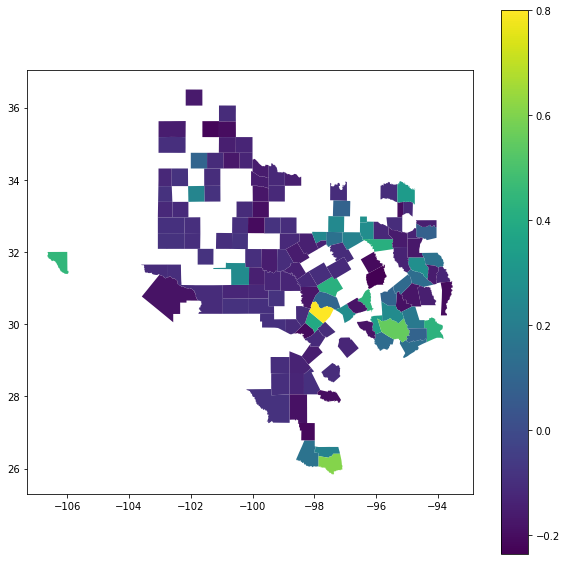

In [7]:
pearson_p05 = pearson_gdf[pearson_gdf["pvals"] <= 0.05]
pearson_p05.plot(column="coefs", figsize=(10, 10), legend=True)

# Spearman

In [8]:
spearman_dict = dict()
for ind in tqdm(access["index"], position=0):
    acc_ts = access.loc[access["index"] == ind].copy(deep=True)
    assert len(acc_ts) == 1
    acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
    acc_ts = acc_ts.T
    acc_ts.columns = ["access"]
    # print(type(acc_ts))
    # acc_ts.head()

    death_ts = death.loc[death["index"] == ind].copy(deep=True)
    assert len(death_ts) == 1
    death_ts = death_ts.drop(columns=["index", "NAME", "TSA", "geometry"])
    # print(list(death_ts.columns))
    death_ts = death_ts.T
    death_ts.columns = ["death"]
    # print(type(death_ts))
    # death_ts.head()

    # need to make the data stationary
    # https://stackoverflow.com/questions/51772493/understanding-output-from-statsmodels-grangercausalitytests
    # https://en.wikipedia.org/wiki/Granger_causality#Method
    #data = acc_ts.join(death_ts)
    #print(len(data))
    x = acc_ts["access"]
    y = death_ts["death"]
    pearr, pearp = spearmanr(x, y)
    spearman_dict[ind] = dict()
    spearman_dict[ind]["coef"] = pearr
    spearman_dict[ind]["pval"] = pearp

  0%|          | 0/254 [00:00<?, ?it/s]/home/dijkstra/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
100%|██████████| 254/254 [00:01<00:00, 137.27it/s]


In [9]:
coefs = [spearman_dict[ind]["coef"] for ind in access["index"]]
pvals = [spearman_dict[ind]["pval"] for ind in access["index"]]
spearman_df = pd.DataFrame({"index": access["index"], "coefs": coefs, "pvals": pvals})
spearman_df.head()

,index,coefs,pvals
0,48327,-0.320837,2.500904e-15
1,48189,-0.190634,3.844360e-06
2,48011,-0.295428,3.989484e-13
3,48057,-0.175236,2.231744e-05
4,48077,-0.385072,6.637880e-22


In [10]:
spearman_gdf = access.copy(deep=True)
spearman_gdf = spearman_gdf.merge(spearman_df, on="index")
spearman_gdf.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry,coefs,pvals
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",-0.320837,2.500904e-15
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8...",-0.190634,3.844360e-06
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0...",-0.295428,3.989484e-13
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508...",-0.175236,2.231744e-05
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813...",-0.385072,6.637880e-22


<AxesSubplot:>

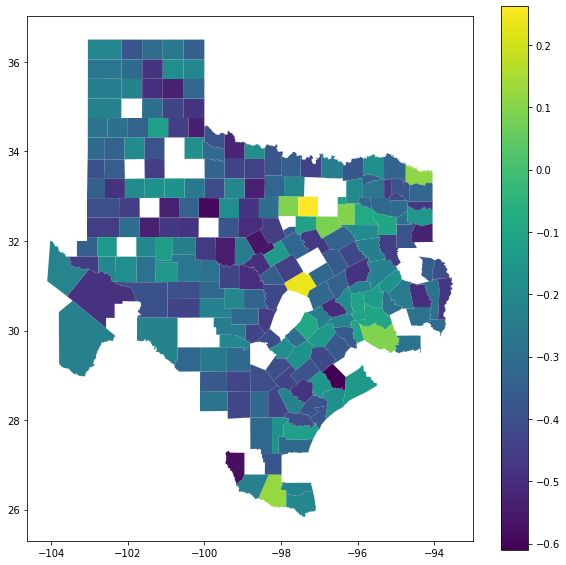

In [11]:
spearman_p05 = spearman_gdf[spearman_gdf["pvals"] <= 0.05]
spearman_p05.plot(column="coefs", figsize=(10, 10), legend=True)

# Granger Causality

First we have to check for stationarity. We will use the code and suggestions from this [statsmodels example](https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html). The methods are slightly altered from that guide to include a "verbose" argument and to return the p-value.

In [12]:
def adf_test(timeseries, verbose=False):
    if verbose:
        print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    if verbose:
        print(dfoutput)
    return dfoutput["p-value"]

In [13]:
ind = "48011"

acc_ts = access.loc[access["index"] == ind].copy(deep=True)
acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
acc_ts = acc_ts.T
acc_ts.columns = ["access"]
res = adf_test(x, verbose=True)
print(res)

Results of Dickey-Fuller Test:
Test Statistic                  -2.954933
p-value                          0.039323
#Lags Used                      12.000000
Number of Observations Used    566.000000
Critical Value (1%)             -3.441956
Critical Value (5%)             -2.866660
Critical Value (10%)            -2.569497
dtype: float64
0.0393228247375731


In [14]:
def kpss_test(timeseries, verbose=False):
    if verbose:
        print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    if verbose:
        print(kpss_output)
    return kpss_output["p-value"]

In [23]:
ind = "48189"

acc_ts = access.loc[access["index"] == ind].copy(deep=True)
acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
acc_ts = acc_ts.T
acc_ts.columns = ["access"]
x = np.diff(x)[1:]
# we want p-value to be high.
# null hypothesis is that the process is trend stationary
res = kpss_test(x, verbose=True)
print(res)

Results of KPSS Test:
Test Statistic           0.021259
p-value                  0.100000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
0.1


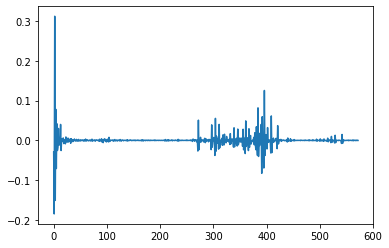

In [24]:
plt.plot(x)

We will apply both of these stationarity tests to the time series to ensure that we can calculate Granger Causality.

In [17]:
def get_most_significant_lag(granger_result):
    best_lag = 0
    min_pval = 1
    for lag in granger_result.keys():
        pval = granger_result[lag][0]["ssr_ftest"][1]
        if pval < min_pval:
            best_lag = lag
            min_pval = pval
    return (best_lag, min_pval)

In [25]:
import warnings
# warnings come from KPSS f stastistic lookup.
warnings.filterwarnings("ignore")
# the failures seem to be due to constant values
# i.e. if access is always zero, there is no
# way to calculate this

# we to verify that differencing results in stationarity

# seems the warnings are gone?
#import warnings
#warnings.filterwarnings("ignore")
# we need to look more deeply into the warnings
# the only thing I found was this, which likely doesn't apply:
# https://github.com/statsmodels/statsmodels/issues/7218

adf_sig = 0.05
kpss_sig = 0.05
max_lag = 60
granger_results = {}
for ind in tqdm(access["index"], position=0):
    acc_ts = access.loc[access["index"] == ind].copy(deep=True)
    assert len(acc_ts) == 1
    acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
    acc_ts = acc_ts.T
    acc_ts.columns = ["access"]
    # print(type(acc_ts))
    # acc_ts.head()

    death_ts = death.loc[death["index"] == ind].copy(deep=True)
    assert len(death_ts) == 1
    death_ts = death_ts.drop(columns=["index", "NAME", "TSA", "geometry"])
    # print(list(death_ts.columns))
    death_ts = death_ts.T
    death_ts.columns = ["death"]
    # print(type(death_ts))
    # death_ts.head()

    # need to make the data stationary
    # https://stackoverflow.com/questions/51772493/understanding-output-from-statsmodels-grangercausalitytests
    # https://en.wikipedia.org/wiki/Granger_causality#Method
    #data = acc_ts.join(death_ts)
    #print(len(data))
    # second order differencing needed for KPSS to pass on many counties
    # https://otexts.com/fpp2/stationarity.html
    x = np.diff(acc_ts["access"])[1:]
    x = np.diff(x)[1:]
    y = np.diff(death_ts["death"])[1:]
    y = np.diff(y)[1:]
    data = pd.DataFrame({"access": x, "death": y})
    # data.head()
    try:
        # check for stationarity
        pval = adf_test(x)
        if pval >= adf_sig:
            print(f"{ind} access is non-stationary per adf with pval {pval}")
            assert False
        pval = adf_test(y)
        if pval >= adf_sig:
            print(f"{ind} death is non-stationary per adf with pval {pval}")
            assert False
        pval = kpss_test(x)
        if pval <= kpss_sig:
            print(f"{ind} access is non-stationary per kpss with pval {pval}")
            assert False
        pval = kpss_test(y)
        if pval <= kpss_sig:
            print(f"{ind} death is non-stationary per kpss with pval {pval}")
            assert False
        
        result = grangercausalitytests(data, maxlag=max_lag, verbose=False)
        lag, pval = get_most_significant_lag(result)
        granger_results[ind] = dict()
        granger_results[ind]["lag"] = lag
        granger_results[ind]["pval"] = pval
    except:
        print(f"{ind} failed")
        granger_results[ind] = dict()
        granger_results[ind]["lag"] = np.nan
        granger_results[ind]["pval"] = np.nan

  4%|▍         | 10/254 [00:15<07:11,  1.77s/it]

48247 failed


 24%|██▎       | 60/254 [01:47<04:13,  1.30s/it]

48211 death is non-stationary per kpss with pval 0.041666666666652766
48211 failed


 28%|██▊       | 71/254 [02:10<04:48,  1.58s/it]

48137 failed


 34%|███▍      | 86/254 [02:35<03:18,  1.18s/it]

48385 failed


 36%|███▌      | 91/254 [02:42<03:04,  1.13s/it]

48345 failed


 38%|███▊      | 97/254 [02:50<02:56,  1.12s/it]

48377 failed


 48%|████▊     | 123/254 [03:32<02:27,  1.13s/it]

48229 failed


 56%|█████▌    | 141/254 [04:01<02:09,  1.15s/it]

48243 failed


 65%|██████▍   | 165/254 [04:47<02:11,  1.47s/it]

48443 failed


 69%|██████▊   | 174/254 [05:02<01:41,  1.27s/it]

48039 death is non-stationary per kpss with pval 0.04695650612188601
48039 failed


 73%|███████▎  | 186/254 [05:22<01:26,  1.27s/it]

48421 death is non-stationary per kpss with pval 0.04166666666666828
48421 failed


 79%|███████▉  | 201/254 [05:44<00:46,  1.15it/s]

48301 failed
48125 failed


 83%|████████▎ | 210/254 [05:58<00:55,  1.25s/it]

48269 failed


 84%|████████▍ | 214/254 [06:02<00:31,  1.27it/s]

48425 access is non-stationary per kpss with pval 0.046231429714796414
48425 failed
48261 failed


 85%|████████▍ | 215/254 [06:02<00:23,  1.64it/s]

48033 failed


100%|██████████| 254/254 [07:13<00:00,  1.71s/it]


In [26]:
lags = [granger_results[ind]["lag"] for ind in access["index"]]
pvals = [granger_results[ind]["pval"] for ind in access["index"]]
result_df = pd.DataFrame({"index": access["index"], "lag": lags, "pvals": pvals})
result_df.head()

,index,lag,pvals
0,48327,1.0,9.699208e-01
1,48189,36.0,4.507060e-53
2,48011,26.0,1.005592e-09
3,48057,45.0,6.072516e-02
4,48077,12.0,4.913610e-04


In [27]:
caus = access.copy(deep=True)
caus = caus.merge(result_df, on="index")
caus.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry,lag,pvals
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",1.0,9.699208e-01
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8...",36.0,4.507060e-53
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0...",26.0,1.005592e-09
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508...",45.0,6.072516e-02
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813...",12.0,4.913610e-04


<AxesSubplot:>

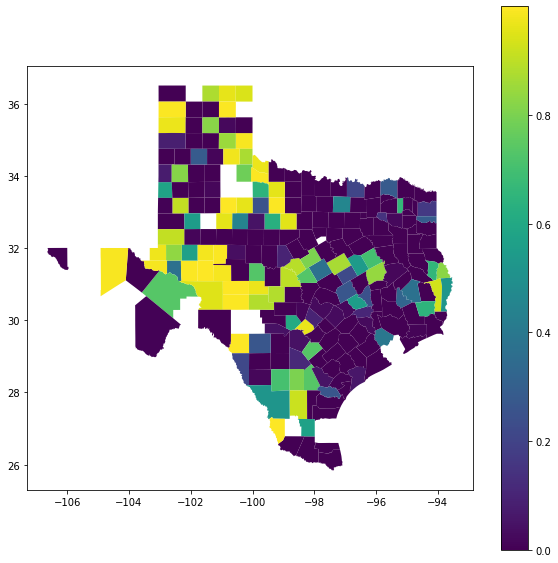

In [28]:
caus.plot(column="pvals", figsize=(10, 10), legend=True)

Text(0.5, 1.0, 'Lag with p-value <= 0.01')

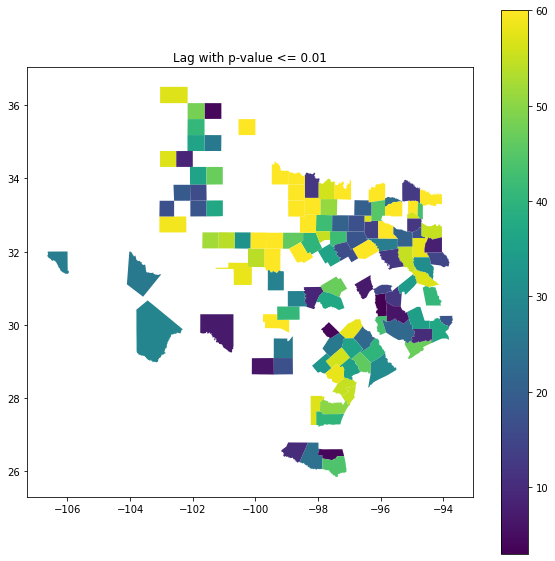

In [29]:
p01 = caus[caus["pvals"] <= 0.01]
p01.plot(column="lag", figsize=(10, 10), legend=True)
plt.title("Lag with p-value <= 0.01")